In [1]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression  
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from scikeras.wrappers import KerasClassifier  
from tensorflow.keras.callbacks import ModelCheckpoint
import keras_tuner as kt

In [2]:
data = {
    'model_name': 'Tire Fault Detection Model',
    'accuracy': 0.95,
    'parameters': {'learning_rate': 0.001, 'epochs': 50}
}

with open('tire_fault_detection_model.pkl', 'wb') as f:
        pickle.dump(data, f)

print("Data has been pickled and saved to tire_fault_detection_model.pkl")

with open('tire_fault_detection_model.pkl', 'rb') as f:
    
    loaded_data = pickle.load(f)

print("Loaded Data:")
print(loaded_data)

print(os.getcwd())
with open('C:/Users/rmks2/Capstone Project/tire-fault-detection/models/tire_fault_detection_model.pkl', 'wb') as f:
    pickle.dump(data, f)


Data has been pickled and saved to tire_fault_detection_model.pkl
Loaded Data:
{'model_name': 'Tire Fault Detection Model', 'accuracy': 0.95, 'parameters': {'learning_rate': 0.001, 'epochs': 50}}
C:\Users\rmks2\Capstone Project\tire-fault-detection\notebooks


In [3]:

# Paths to good and faulty tire images
good_tire_path = 'C:/Users/rmks2/Capstone Project/tire-fault-detection/dataset/raw/good'
faulty_tire_path = 'C:/Users/rmks2/Capstone Project/tire-fault-detection/dataset/raw/defective'

# Paths to save processed good and faulty tire images
processed_good_tire_path = 'C:/Users/rmks2/Capstone Project/tire-fault-detection/dataset/processed/good'
processed_faulty_tire_path = 'C:/Users/rmks2/Capstone Project/tire-fault-detection/dataset/processed/defective'

# Creating directories for processed images
os.makedirs(processed_good_tire_path, exist_ok=True)
os.makedirs(processed_faulty_tire_path, exist_ok=True)



In [4]:
# Data cleaning function
def clean_data(image_paths, processed_path):
    cleaned_images = []
    for img_path in image_paths:
        try:
            # Loading the image to check if it's valid
            img = load_img(img_path)
            cleaned_images.append(img_path)  
            
            # Saving the cleaned image to the processed path
            img_array = img_to_array(img)  # Converting image to array 
            save_img(os.path.join(processed_path, os.path.basename(img_path)), img_array)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
    return cleaned_images

# Loading and cleaning the dataset
def load_and_clean_data(good_tire_path, faulty_tire_path):
    good_tires = [os.path.join(good_tire_path, img) for img in os.listdir(good_tire_path)]
    faulty_tires = [os.path.join(faulty_tire_path, img) for img in os.listdir(faulty_tire_path)]
    
    print(f"Total Good Tires (before cleaning): {len(good_tires)}")
    print(f"Total Faulty Tires (before cleaning): {len(faulty_tires)}")
    
    # Cleaning the datasets and saving processed images
    good_tires_cleaned = clean_data(good_tires, processed_good_tire_path)
    faulty_tires_cleaned = clean_data(faulty_tires, processed_faulty_tire_path)

    print(f"Total Good Tires (after cleaning): {len(good_tires_cleaned)}")
    print(f"Total Faulty Tires (after cleaning): {len(faulty_tires_cleaned)}")
    
    return good_tires_cleaned, faulty_tires_cleaned

# Loading the cleaned dataset
good_tires, faulty_tires = load_and_clean_data(good_tire_path, faulty_tire_path)

Total Good Tires (before cleaning): 828
Total Faulty Tires (before cleaning): 1028
Total Good Tires (after cleaning): 828
Total Faulty Tires (after cleaning): 1028


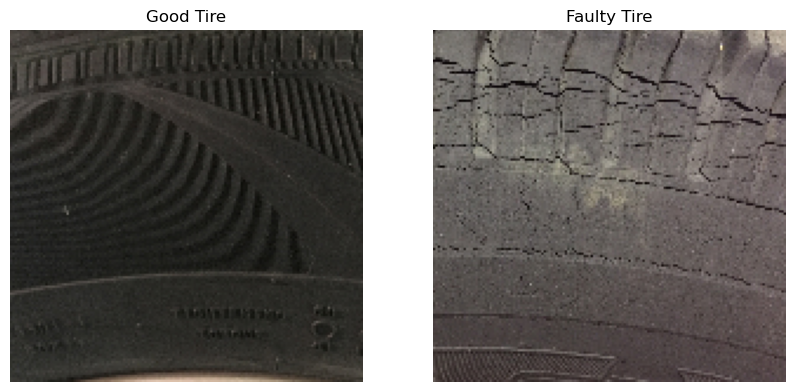

In [5]:
# Displaying sample images of good and faulty tires
def display_samples(good_tires, faulty_tires):
    plt.figure(figsize=(10, 5))
    
    # Displaying a sample good tire image
    plt.subplot(1, 2, 1)
    good_sample = load_img(good_tires[0], target_size=(150, 150))
    plt.imshow(good_sample)
    plt.title('Good Tire')
    plt.axis('off')

    # Displaying a sample faulty tire image
    plt.subplot(1, 2, 2)
    faulty_sample = load_img(faulty_tires[0], target_size=(150, 150))
    plt.imshow(faulty_sample)
    plt.title('Faulty Tire')
    plt.axis('off')
    plt.savefig('sample_good&fault_tire.png')
    plt.show()

display_samples(good_tires, faulty_tires)


In [6]:
# Creating an ImageDataGenerator for preprocessing the images with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)

In [7]:
# Loading training and validation data using flow_from_directory
train_generator = train_datagen.flow_from_directory(
    directory='C:/Users/rmks2/Capstone Project/tire-fault-detection/dataset/processed',  # Use processed data directory here
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    directory='C:/Users/rmks2/Capstone Project/tire-fault-detection/dataset/processed',  # Use processed data directory here
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 1486 images belonging to 2 classes.
Found 370 images belonging to 2 classes.


In [8]:
# Defining the model creation function for Keras Tuner and Grid Search
def build_model(hp):
    model = Sequential([
        Input(shape=(150, 150, 3)),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(hp.Choice('dropout_rate', [0.3, 0.5])),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
# Initializing the tuner for hyperparameter tuning using Keras Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
)

# Runing the hyperparameter searching with Keras Tuner on training data generator.
tuner.search(train_generator, validation_data=validation_generator, epochs=10)

# Getting the best hyperparameters from Keras Tuner.
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters.
model = build_model(best_hps)

# Training the model.
history = model.fit(train_generator, validation_data=validation_generator, epochs=10)

Trial 1 Complete [00h 28m 21s]
val_accuracy: 0.7567567825317383

Best val_accuracy So Far: 0.7567567825317383
Total elapsed time: 00h 28m 21s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
0.3               |0.5               |dropout_rate

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 170s 4s/step - accuracy: 0.5161 - loss: 1.3470 - val_accuracy: 0.5351 - val_loss: 0.6747
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 178s 4s/step - accuracy: 0.5680 - loss: 0.6805 - val_accuracy: 0.7081 - val_loss: 0.6157
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 214s 5s/step - accuracy: 0.6638 - loss: 0.6250 - val_accuracy: 0.7027 - val_loss: 0.5797
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 197s 4s/step - accuracy: 0.6523 - loss: 0.6306 - val_accuracy: 0.7324 - val_loss: 0.5572
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 180s 4s/step - accuracy: 0.6709 - loss: 0.6076 - val_accuracy: 0.7000 - val_loss: 0.5827
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 159s 3s/step - accuracy: 0.6637 - loss: 0.6143 - val_

In [ ]:
# Plotting training and validation accuracy and loss.
plt.figure(figsize=(12, 4))

# Plot accuracy.
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot loss.
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig('Training and Validation Loss.png')
plt.show()

In [ ]:
# Preparing to evaluate traditional models on flattened data.
X_flattened = np.array([img_to_array(load_img(img_path, target_size=(150, 150))) / 
                        255.0 for img_path in good_tires + faulty_tires])

y_flattened = np.array([0] * len(good_tires) + [1] * len(faulty_tires)) 

# Split into train and test sets (80% train, 20% test).
X_train_flattened , X_test_flattened , y_train_flattened , y_test_flattened = train_test_split(
     X_flattened.reshape(X_flattened.shape[0], -1), 
     y_flattened , 
     test_size=0.2 , 
     random_state=42)


In [ ]:
# Logistic Regression Model with evaluation metrics.
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_flattened , y_train_flattened)
y_pred_log_reg = log_reg.predict(X_test_flattened)
accuracy_log_reg = accuracy_score(y_test_flattened , y_pred_log_reg)
print(f"Test Accuracy (Logistic Regression): {accuracy_log_reg:.2f}")
print(classification_report(y_test_flattened , y_pred_log_reg))

In [ ]:
# Decision Tree Model with evaluation metrics.
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train_flattened , y_train_flattened)
y_pred_dt = dt_model.predict(X_test_flattened)
accuracy_dt = accuracy_score(y_test_flattened , y_pred_dt)
print(f"Test Accuracy (Decision Tree): {accuracy_dt:.2f}")
print(classification_report(y_test_flattened , y_pred_dt))


In [ ]:
# Random Forest Model with evaluation metrics.
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train_flattened , y_train_flattened)
y_pred_rf = rf_model.predict(X_test_flattened)
accuracy_rf = accuracy_score(y_test_flattened , y_pred_rf)
print(f"Test Accuracy (Random Forest): {accuracy_rf:.2f}")
print(classification_report(y_test_flattened , y_pred_rf))

In [ ]:
# Evaluate the best model on validation data 
val_loss , val_accuracy = model.evaluate(validation_generator)
print(f'Validation Accuracy (Best Model): {val_accuracy:.4f}')

In [ ]:
# Visualizing performance of each model using bar charts.
model_names = ['CNN', 'Logistic Regression', 'Decision Tree', 'Random Forest']
accuracies = [val_accuracy] + [accuracy_log_reg] + [accuracy_dt] + [accuracy_rf]

plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
# Setting limits from 0 to 1 for accuracy percentage
plt.ylim([0.0, 1.0]) 

for i in range(len(model_names)):
    plt.text(i - 0.1 if i != 0 else i + 0.1 , accuracies[i] + 0.01 if accuracies[i] < 1 else accuracies[i], f'{accuracies[i]:.2f}', ha='center')

plt.tight_layout()
plt.savefig('model_performance_comparison.png')
plt.show()

In [ ]:
# Displaying confusion matrix for better understanding of misclassifications for Logistic Regression.
conf_matrix_log_reg = confusion_matrix(y_test_flattened , y_pred_log_reg)
plt.figure(figsize=(8 , 6))
plt.imshow(conf_matrix_log_reg , interpolation='nearest' , cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Logistic Regression')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks , ['Good Tire' , 'Faulty Tire'])
plt.yticks(tick_marks , ['Good Tire' , 'Faulty Tire'])

for i in range(conf_matrix_log_reg.shape[0]):
     for j in range(conf_matrix_log_reg.shape[1]):
         plt.text(j ,
                  i ,
                  format(conf_matrix_log_reg[i][j] , 'd') ,
                  horizontalalignment="center",
                  color="white" if conf_matrix_log_reg[i][j] > conf_matrix_log_reg.max()/2 else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig('model_performance.png')
plt.show()

